In [ ]:
!pip install transformers==4.26.1
!pip install diffusers==0.12.1
!pip install "jax[cuda12_local]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install datasets==2.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 13.2 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully unin

## Clip

In [ ]:
import torch

class Embed(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.embed = torch.nn.Embedding(49408, 768)
        self.pos_embed = torch.nn.Embedding(77, 768)

        self.register_buffer('pos_ids', torch.arange(77).unsqueeze(dim=0))

    def forward(self, input_ids):
        #input_ids -> [b, 77]

        #[b, 77] -> [b, 77, 768]
        embed = self.embed(input_ids)

        #[1, 77] -> [1, 77, 768]
        pos_embed = self.pos_embed(self.pos_ids)

        #[b, 77, 768]
        return embed + pos_embed


In [ ]:
class Atten(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.q = torch.nn.Linear(768, 768)
        self.k = torch.nn.Linear(768, 768)
        self.v = torch.nn.Linear(768, 768)
        self.out = torch.nn.Linear(768, 768)

    def forward(self, x):
        #x -> [b, 77, 768]

        b = x.shape[0]

        #keep dimension
        #[b, 77, 768]
        q = self.q(x) * 0.125
        k = self.k(x)
        v = self.v(x)

        #multi-attention
        #[b, 77, 768] -> [b, 77, 12, 64] -> [b, 12, 77, 64] -> [b*12, 77, 64]
        q = q.reshape(b, 77, 12, 64).transpose(1, 2).reshape(b * 12, 77, 64)
        k = k.reshape(b, 77, 12, 64).transpose(1, 2).reshape(b * 12, 77, 64)
        v = v.reshape(b, 77, 12, 64).transpose(1, 2).reshape(b * 12, 77, 64)

        #q * k
        #[b*12, 77, 64] * [b*12, 64, 77] -> [b*12, 77, 77]
        attn = torch.bmm(q, k.transpose(1, 2))

        #[b*12, 77, 77] -> [b, 12, 77, 77]
        attn = attn.reshape(b, 12, 77, 77)

        #mask
        def get_mask(b):
            mask = torch.empty(b, 77, 77)


            mask.fill_(-float('inf'))


            mask.triu_(1)

            return mask.unsqueeze(1)

        #[b, 12, 77, 77] + [b, 1, 77, 77] -> [b, 12, 77, 77]
        attn = attn + get_mask(attn.shape[0]).to(attn.device)

        #[b, 12, 77, 77] -> [b*12, 77, 77]
        attn = attn.reshape(b * 12, 77, 77)

        #masked = 0 in softmax
        attn = attn.softmax(dim=-1)

        #multipy v
        #[b*12, 77, 77] * [b*12, 77, 64] -> [b*12, 77, 64]
        attn = torch.bmm(attn, v)

        #[b*12, 77, 64] -> [b, 12, 77, 64] -> [b, 77, 12, 64] -> [b, 77, 768]
        attn = attn.reshape(b, 12, 77, 64).transpose(1, 2).reshape(b, 77, 768)


        #[b, 77, 768]
        return self.out(attn)


In [ ]:
class ClipEncoder(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.s1 = torch.nn.Sequential(
            torch.nn.LayerNorm(768),
            Atten(),
        )

        self.s2 = torch.nn.Sequential(
            torch.nn.LayerNorm(768),
            torch.nn.Linear(768, 3072),
        )

        self.s3 = torch.nn.Linear(3072, 768)

    def forward(self, x):
        #x -> [2, 77, 768]


        #[2, 77, 768]
        x = x + self.s1(x)

        #[2, 77, 768]
        res = x

        #[2, 77, 768] -> [2, 77, 3072]
        x = self.s2(x)


        #[2, 77, 3072]
        x = x * (x * 1.702).sigmoid()

        #[2, 77, 3072] -> [2, 77, 768]
        return res + self.s3(x)


In [ ]:
encoder = torch.nn.Sequential(
    Embed(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    ClipEncoder(),
    torch.nn.LayerNorm(768),
)


In [ ]:
from transformers import CLIPTextModel

#load pretrained params
params = CLIPTextModel.from_pretrained(
    'lansinuote/diffsion_from_scratch.params', subfolder='text_encoder')

#text embedding
encoder[0].embed.load_state_dict(
    params.text_model.embeddings.token_embedding.state_dict())

#position embedding
encoder[0].pos_embed.load_state_dict(
    params.text_model.embeddings.position_embedding.state_dict())

#12 embedding layers
for i in range(12):

    #1st norm
    encoder[i + 1].s1[0].load_state_dict(
        params.text_model.encoder.layers[i].layer_norm1.state_dict())

    #attention q matrix
    encoder[i + 1].s1[1].q.load_state_dict(
        params.text_model.encoder.layers[i].self_attn.q_proj.state_dict())

    #attention k matrix
    encoder[i + 1].s1[1].k.load_state_dict(
        params.text_model.encoder.layers[i].self_attn.k_proj.state_dict())

    #attention v matrix
    encoder[i + 1].s1[1].v.load_state_dict(
        params.text_model.encoder.layers[i].self_attn.v_proj.state_dict())

    #attention out
    encoder[i + 1].s1[1].out.load_state_dict(
        params.text_model.encoder.layers[i].self_attn.out_proj.state_dict())

    #2nd norm
    encoder[i + 1].s2[0].load_state_dict(
        params.text_model.encoder.layers[i].layer_norm2.state_dict())

    #1st fc of mlp
    encoder[i + 1].s2[1].load_state_dict(
        params.text_model.encoder.layers[i].mlp.fc1.state_dict())

    #2nd fc of mlp
    encoder[i + 1].s3.load_state_dict(
        params.text_model.encoder.layers[i].mlp.fc2.state_dict())

# output norm
encoder[13].load_state_dict(params.text_model.final_layer_norm.state_dict())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


text_encoder/config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
a = encoder(torch.arange(77).unsqueeze(dim=0))
b = params(torch.arange(77).unsqueeze(dim=0)).last_hidden_state

(a == b).all()

tensor(True)

## VAE

In [ ]:

class Resnet(torch.nn.Module):

    def __init__(self, dim_in, dim_out):
        super().__init__()

        self.s = torch.nn.Sequential(
            torch.nn.GroupNorm(num_groups=32,
                               num_channels=dim_in,
                               eps=1e-6,
                               affine=True),
            torch.nn.SiLU(),
            torch.nn.Conv2d(dim_in,
                            dim_out,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.GroupNorm(num_groups=32,
                               num_channels=dim_out,
                               eps=1e-6,
                               affine=True),
            torch.nn.SiLU(),
            torch.nn.Conv2d(dim_out,
                            dim_out,
                            kernel_size=3,
                            stride=1,
                            padding=1),
        )

        self.res = None
        if dim_in != dim_out:
            self.res = torch.nn.Conv2d(dim_in,
                                       dim_out,
                                       kernel_size=1,
                                       stride=1,
                                       padding=0)

    def forward(self, x):
        #x -> [1, 128, 10, 10]

        res = x
        if self.res:
            #[1, 128, 10, 10] -> [1, 256, 10, 10]
            res = self.res(x)

        #[1, 128, 10, 10] -> [1, 256, 10, 10]
        return res + self.s(x)


Resnet(128, 256)(torch.randn(1, 128, 10, 10)).shape

torch.Size([1, 256, 10, 10])

In [ ]:
class Atten(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.norm = torch.nn.GroupNorm(num_channels=512,
                                       num_groups=32,
                                       eps=1e-6,
                                       affine=True)

        self.q = torch.nn.Linear(512, 512)
        self.k = torch.nn.Linear(512, 512)
        self.v = torch.nn.Linear(512, 512)
        self.out = torch.nn.Linear(512, 512)

    def forward(self, x):
        #x -> [1, 512, 64, 64]
        res = x

        #norm
        #[1, 512, 64, 64]
        x = self.norm(x)

        #[1, 512, 64, 64] -> [1, 512, 4096] -> [1, 4096, 512]
        x = x.flatten(start_dim=2).transpose(1, 2)


        #[1, 4096, 512]
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        #[1, 4096, 512] -> [1, 512, 4096]
        k = k.transpose(1, 2)

        #[1, 4096, 512] * [1, 512, 4096] -> [1, 4096, 4096]
        #0.044194173824159216 = 1 / 512**0.5
        #atten = q.bmm(k) * 0.044194173824159216

        #照理来说应该是等价的,但是却有很小的误差
        atten = torch.baddbmm(torch.empty(1, 4096, 4096, device=q.device),
                              q,
                              k,
                              beta=0,
                              alpha=0.044194173824159216)

        atten = torch.softmax(atten, dim=2)

        #[1, 4096, 4096] * [1, 4096, 512] -> [1, 4096, 512]
        atten = atten.bmm(v)


        #[1, 4096, 512]
        atten = self.out(atten)

        #[1, 4096, 512] -> [1, 512, 4096] -> [1, 512, 64, 64]
        atten = atten.transpose(1, 2).reshape(-1, 512, 64, 64)

        #connect res
        #[1, 512, 64, 64]
        atten = atten + res

        return atten


Atten()(torch.randn(1, 512, 64, 64)).shape

torch.Size([1, 512, 64, 64])

In [ ]:
class Pad(torch.nn.Module):

    def forward(self, x):
        return torch.nn.functional.pad(x, (0, 1, 0, 1),
                                       mode='constant',
                                       value=0)


Pad()(torch.ones(1, 2, 5, 5))

tensor([[[[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0.]],

         [[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0.]]]])

In [ ]:
class VAE(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            #in
            torch.nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),

            #down
            torch.nn.Sequential(
                Resnet(128, 128),
                Resnet(128, 128),
                torch.nn.Sequential(
                    Pad(),
                    torch.nn.Conv2d(128, 128, 3, stride=2, padding=0),
                ),
            ),
            torch.nn.Sequential(
                Resnet(128, 256),
                Resnet(256, 256),
                torch.nn.Sequential(
                    Pad(),
                    torch.nn.Conv2d(256, 256, 3, stride=2, padding=0),
                ),
            ),
            torch.nn.Sequential(
                Resnet(256, 512),
                Resnet(512, 512),
                torch.nn.Sequential(
                    Pad(),
                    torch.nn.Conv2d(512, 512, 3, stride=2, padding=0),
                ),
            ),
            torch.nn.Sequential(
                Resnet(512, 512),
                Resnet(512, 512),
            ),

            #mid
            torch.nn.Sequential(
                Resnet(512, 512),
                Atten(),
                Resnet(512, 512),
            ),

            #out
            torch.nn.Sequential(
                torch.nn.GroupNorm(num_channels=512, num_groups=32, eps=1e-6),
                torch.nn.SiLU(),
                torch.nn.Conv2d(512, 8, 3, padding=1),
            ),

            torch.nn.Conv2d(8, 8, 1),
        )

        self.decoder = torch.nn.Sequential(

            torch.nn.Conv2d(4, 4, 1),

            #in
            torch.nn.Conv2d(4, 512, kernel_size=3, stride=1, padding=1),

            #middle
            torch.nn.Sequential(Resnet(512, 512), Atten(), Resnet(512, 512)),

            #up
            torch.nn.Sequential(
                Resnet(512, 512),
                Resnet(512, 512),
                Resnet(512, 512),
                torch.nn.Upsample(scale_factor=2.0, mode='nearest'),
                torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ),
            torch.nn.Sequential(
                Resnet(512, 512),
                Resnet(512, 512),
                Resnet(512, 512),
                torch.nn.Upsample(scale_factor=2.0, mode='nearest'),
                torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ),
            torch.nn.Sequential(
                Resnet(512, 256),
                Resnet(256, 256),
                Resnet(256, 256),
                torch.nn.Upsample(scale_factor=2.0, mode='nearest'),
                torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            ),
            torch.nn.Sequential(
                Resnet(256, 128),
                Resnet(128, 128),
                Resnet(128, 128),
            ),

            #out
            torch.nn.Sequential(
                torch.nn.GroupNorm(num_channels=128, num_groups=32, eps=1e-6),
                torch.nn.SiLU(),
                torch.nn.Conv2d(128, 3, 3, padding=1),
            ),
        )

    def sample(self, h):
        #h -> [1, 8, 64, 64]

        #[1, 4, 64, 64]
        mean = h[:, :4]
        logvar = h[:, 4:]
        std = logvar.exp()**0.5

        #[1, 4, 64, 64]
        h = torch.randn(mean.shape, device=mean.device)
        h = mean + std * h

        return h

    def forward(self, x):
        #x -> [1, 3, 512, 512]

        #[1, 3, 512, 512] -> [1, 8, 64, 64]
        h = self.encoder(x)

        #[1, 8, 64, 64] -> [1, 4, 64, 64]
        h = self.sample(h)

        #[1, 4, 64, 64] -> [1, 3, 512, 512]
        h = self.decoder(h)

        return h


VAE()(torch.randn(1, 3, 512, 512)).shape

torch.Size([1, 3, 512, 512])

In [ ]:
from diffusers import AutoencoderKL

#load pre-trained params
params = AutoencoderKL.from_pretrained(
    'lansinuote/diffsion_from_scratch.params', subfolder='vae')

vae = VAE()


def load_res(model, param):
    model.s[0].load_state_dict(param.norm1.state_dict())
    model.s[2].load_state_dict(param.conv1.state_dict())
    model.s[3].load_state_dict(param.norm2.state_dict())
    model.s[5].load_state_dict(param.conv2.state_dict())

    if isinstance(model.res, torch.nn.Module):
        model.res.load_state_dict(param.conv_shortcut.state_dict())


def load_atten(model, param):
    model.norm.load_state_dict(param.group_norm.state_dict())
    model.q.load_state_dict(param.query.state_dict())
    model.k.load_state_dict(param.key.state_dict())
    model.v.load_state_dict(param.value.state_dict())
    model.out.load_state_dict(param.proj_attn.state_dict())


#encoder.in
vae.encoder[0].load_state_dict(params.encoder.conv_in.state_dict())

#encoder.down
for i in range(4):
    load_res(vae.encoder[i + 1][0], params.encoder.down_blocks[i].resnets[0])
    load_res(vae.encoder[i + 1][1], params.encoder.down_blocks[i].resnets[1])

    if i != 3:
        vae.encoder[i + 1][2][1].load_state_dict(
            params.encoder.down_blocks[i].downsamplers[0].conv.state_dict())

#encoder.mid
load_res(vae.encoder[5][0], params.encoder.mid_block.resnets[0])
load_res(vae.encoder[5][2], params.encoder.mid_block.resnets[1])
load_atten(vae.encoder[5][1], params.encoder.mid_block.attentions[0])

#encoder.out
vae.encoder[6][0].load_state_dict(params.encoder.conv_norm_out.state_dict())
vae.encoder[6][2].load_state_dict(params.encoder.conv_out.state_dict())

#encoder.GD
vae.encoder[7].load_state_dict(params.quant_conv.state_dict())

#decoder.GD
vae.decoder[0].load_state_dict(params.post_quant_conv.state_dict())

#decoder.in
vae.decoder[1].load_state_dict(params.decoder.conv_in.state_dict())

#decoder.mid
load_res(vae.decoder[2][0], params.decoder.mid_block.resnets[0])
load_res(vae.decoder[2][2], params.decoder.mid_block.resnets[1])
load_atten(vae.decoder[2][1], params.decoder.mid_block.attentions[0])

#decoder.up
for i in range(4):
    load_res(vae.decoder[i + 3][0], params.decoder.up_blocks[i].resnets[0])
    load_res(vae.decoder[i + 3][1], params.decoder.up_blocks[i].resnets[1])
    load_res(vae.decoder[i + 3][2], params.decoder.up_blocks[i].resnets[2])

    if i != 3:
        vae.decoder[i + 3][4].load_state_dict(
            params.decoder.up_blocks[i].upsamplers[0].conv.state_dict())

#decoder.out
vae.decoder[7][0].load_state_dict(params.decoder.conv_norm_out.state_dict())
vae.decoder[7][2].load_state_dict(params.decoder.conv_out.state_dict())

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


<All keys matched successfully>

In [ ]:
data = torch.randn(1, 3, 512, 512)

a = vae.encoder(data)
b = params.encode(data).latent_dist.parameters

(a == b).all()

tensor(True)

In [ ]:
data = torch.randn(1, 4, 64, 64)

a = vae.decoder(data)
b = params.decode(data).sample

(a == b).all()

tensor(True)

## Unet

In [ ]:
class Resnet(torch.nn.Module):

    def __init__(self, dim_in, dim_out):
        super().__init__()

        self.time = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.torch.nn.Linear(1280, dim_out),
            torch.nn.Unflatten(dim=1, unflattened_size=(dim_out, 1, 1)),
        )

        self.s0 = torch.nn.Sequential(
            torch.torch.nn.GroupNorm(num_groups=32,
                                     num_channels=dim_in,
                                     eps=1e-05,
                                     affine=True),
            torch.nn.SiLU(),
            torch.torch.nn.Conv2d(dim_in,
                                  dim_out,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
        )

        self.s1 = torch.nn.Sequential(
            torch.torch.nn.GroupNorm(num_groups=32,
                                     num_channels=dim_out,
                                     eps=1e-05,
                                     affine=True),
            torch.nn.SiLU(),
            torch.torch.nn.Conv2d(dim_out,
                                  dim_out,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
        )

        self.res = None
        if dim_in != dim_out:
            self.res = torch.torch.nn.Conv2d(dim_in,
                                             dim_out,
                                             kernel_size=1,
                                             stride=1,
                                             padding=0)

    def forward(self, x, time):
        #x -> [1, 320, 64, 64]
        #time -> [1, 1280]

        res = x

        #[1, 1280] -> [1, 640, 1, 1]
        time = self.time(time)

        #[1, 320, 64, 64] -> [1, 640, 32, 32]
        x = self.s0(x) + time


        #[1, 640, 32, 32]
        x = self.s1(x)

        #[1, 320, 64, 64] -> [1, 640, 32, 32]
        if self.res:
            res = self.res(res)


        #[1, 640, 32, 32]
        x = res + x

        return x


Resnet(320, 640)(torch.randn(1, 320, 32, 32), torch.randn(1, 1280)).shape

torch.Size([1, 640, 32, 32])

In [ ]:
class CrossAttention(torch.nn.Module):

    def __init__(self, dim_q, dim_kv):
        #dim_q -> 320
        #dim_kv -> 768

        super().__init__()

        self.dim_q = dim_q

        self.q = torch.nn.Linear(dim_q, dim_q, bias=False)
        self.k = torch.nn.Linear(dim_kv, dim_q, bias=False)
        self.v = torch.nn.Linear(dim_kv, dim_q, bias=False)

        self.out = torch.nn.Linear(dim_q, dim_q)

    def forward(self, q, kv):
        #x -> [1, 4096, 320]
        #kv -> [1, 77, 768]

        #[1, 4096, 320] -> [1, 4096, 320]
        q = self.q(q)
        #[1, 77, 768] -> [1, 77, 320]
        k = self.k(kv)
        #[1, 77, 768] -> [1, 77, 320]
        v = self.v(kv)

        def reshape(x):
            #x -> [1, 4096, 320]
            b, lens, dim = x.shape

            #[1, 4096, 320] -> [1, 4096, 8, 40]
            x = x.reshape(b, lens, 8, dim // 8)

            #[1, 4096, 8, 40] -> [1, 8, 4096, 40]
            x = x.transpose(1, 2)

            #[1, 8, 4096, 40] -> [8, 4096, 40]
            x = x.reshape(b * 8, lens, dim // 8)

            return x

        #[1, 4096, 320] -> [8, 4096, 40]
        q = reshape(q)
        #[1, 77, 320] -> [8, 77, 40]
        k = reshape(k)
        #[1, 77, 320] -> [8, 77, 40]
        v = reshape(v)

        #[8, 4096, 40] * [8, 40, 77] -> [8, 4096, 77]
        #atten = q.bmm(k.transpose(1, 2)) * (self.dim_q // 8)**-0.5

        atten = torch.baddbmm(
            torch.empty(q.shape[0], q.shape[1], k.shape[1], device=q.device),
            q,
            k.transpose(1, 2),
            beta=0,
            alpha=(self.dim_q // 8)**-0.5,
        )

        atten = atten.softmax(dim=-1)

        #[8, 4096, 77] * [8, 77, 40] -> [8, 4096, 40]
        atten = atten.bmm(v)

        def reshape(x):
            #x -> [8, 4096, 40]
            b, lens, dim = x.shape

            #[8, 4096, 40] -> [1, 8, 4096, 40]
            x = x.reshape(b // 8, 8, lens, dim)

            #[1, 8, 4096, 40] -> [1, 4096, 8, 40]
            x = x.transpose(1, 2)

            #[1, 4096, 320]
            x = x.reshape(b // 8, lens, dim * 8)

            return x

        #[8, 4096, 40] -> [1, 4096, 320]
        atten = reshape(atten)

        #[1, 4096, 320] -> [1, 4096, 320]
        atten = self.out(atten)

        return atten


CrossAttention(320, 768)(torch.randn(1, 4096, 320), torch.randn(1, 77,
                                                                768)).shape

torch.Size([1, 4096, 320])

In [ ]:
class Transformer(torch.nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.dim = dim

        #in
        self.norm_in = torch.nn.GroupNorm(num_groups=32,
                                          num_channels=dim,
                                          eps=1e-6,
                                          affine=True)
        self.cnn_in = torch.nn.Conv2d(dim,
                                      dim,
                                      kernel_size=1,
                                      stride=1,
                                      padding=0)

        #atten
        self.norm_atten0 = torch.nn.LayerNorm(dim, elementwise_affine=True)
        self.atten1 = CrossAttention(dim, dim)
        self.norm_atten1 = torch.nn.LayerNorm(dim, elementwise_affine=True)
        self.atten2 = CrossAttention(dim, 768)

        #act
        self.norm_act = torch.nn.LayerNorm(dim, elementwise_affine=True)
        self.fc0 = torch.nn.Linear(dim, dim * 8)
        self.act = torch.nn.GELU()
        self.fc1 = torch.nn.Linear(dim * 4, dim)

        #out
        self.cnn_out = torch.nn.Conv2d(dim,
                                       dim,
                                       kernel_size=1,
                                       stride=1,
                                       padding=0)

    def forward(self, q, kv):
        #q -> [1, 320, 64, 64]
        #kv -> [1, 77, 768]
        b, _, h, w = q.shape
        res1 = q

        #----in----

        #[1, 320, 64, 64]
        q = self.cnn_in(self.norm_in(q))

        #[1, 320, 64, 64] -> [1, 64, 64, 320] -> [1, 4096, 320]
        q = q.permute(0, 2, 3, 1).reshape(b, h * w, self.dim)

        #----atten----

        #[1, 4096, 320]
        q = self.atten1(q=self.norm_atten0(q), kv=self.norm_atten0(q)) + q
        q = self.atten2(q=self.norm_atten1(q), kv=kv) + q

        #----act----
        #[1, 4096, 320]
        res2 = q

        #[1, 4096, 320] -> [1, 4096, 2560]
        q = self.fc0(self.norm_act(q))

        #1280
        d = q.shape[2] // 2

        #[1, 4096, 1280] * [1, 4096, 1280] -> [1, 4096, 1280]
        q = q[:, :, :d] * self.act(q[:, :, d:])

        #[1, 4096, 1280] -> [1, 4096, 320]
        q = self.fc1(q) + res2

        #----out----
        #[1, 4096, 320] -> [1, 64, 64, 320] -> [1, 320, 64, 64]
        q = q.reshape(b, h, w, self.dim).permute(0, 3, 1, 2).contiguous()


        #[1, 320, 64, 64]
        q = self.cnn_out(q) + res1

        return q


Transformer(320)(torch.randn(1, 320, 64, 64), torch.randn(1, 77, 768)).shape

torch.Size([1, 320, 64, 64])

In [ ]:
class DownBlock(torch.nn.Module):

    def __init__(self, dim_in, dim_out):
        super().__init__()

        self.tf0 = Transformer(dim_out)
        self.res0 = Resnet(dim_in, dim_out)

        self.tf1 = Transformer(dim_out)
        self.res1 = Resnet(dim_out, dim_out)

        self.out = torch.nn.Conv2d(dim_out,
                                   dim_out,
                                   kernel_size=3,
                                   stride=2,
                                   padding=1)

    def forward(self, out_vae, out_encoder, time):
        outs = []

        out_vae = self.res0(out_vae, time)
        out_vae = self.tf0(out_vae, out_encoder)
        outs.append(out_vae)

        out_vae = self.res1(out_vae, time)
        out_vae = self.tf1(out_vae, out_encoder)
        outs.append(out_vae)

        out_vae = self.out(out_vae)
        outs.append(out_vae)

        return out_vae, outs


DownBlock(320, 640)(torch.randn(1, 320, 32, 32), torch.randn(1, 77, 768),
                    torch.randn(1, 1280))[0].shape

torch.Size([1, 640, 16, 16])

In [ ]:
class UpBlock(torch.nn.Module):

    def __init__(self, dim_in, dim_out, dim_prev, add_up):
        super().__init__()

        self.res0 = Resnet(dim_out + dim_prev, dim_out)
        self.res1 = Resnet(dim_out + dim_out, dim_out)
        self.res2 = Resnet(dim_in + dim_out, dim_out)

        self.tf0 = Transformer(dim_out)
        self.tf1 = Transformer(dim_out)
        self.tf2 = Transformer(dim_out)

        self.out = None
        if add_up:
            self.out = torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2, mode='nearest'),
                torch.nn.Conv2d(dim_out, dim_out, kernel_size=3, padding=1),
            )

    def forward(self, out_vae, out_encoder, time, out_down):
        out_vae = self.res0(torch.cat([out_vae, out_down.pop()], dim=1), time)
        out_vae = self.tf0(out_vae, out_encoder)

        out_vae = self.res1(torch.cat([out_vae, out_down.pop()], dim=1), time)
        out_vae = self.tf1(out_vae, out_encoder)

        out_vae = self.res2(torch.cat([out_vae, out_down.pop()], dim=1), time)
        out_vae = self.tf2(out_vae, out_encoder)

        if self.out:
            out_vae = self.out(out_vae)

        return out_vae


UpBlock(320, 640, 1280, True)(torch.randn(1, 1280, 32, 32),
                              torch.randn(1, 77, 768), torch.randn(1, 1280), [
                                  torch.randn(1, 320, 32, 32),
                                  torch.randn(1, 640, 32, 32),
                                  torch.randn(1, 640, 32, 32)
                              ]).shape

torch.Size([1, 640, 64, 64])

In [ ]:
class UNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        #in
        self.in_vae = torch.nn.Conv2d(4, 320, kernel_size=3, padding=1)

        self.in_time = torch.nn.Sequential(
            torch.nn.Linear(320, 1280),
            torch.nn.SiLU(),
            torch.nn.Linear(1280, 1280),
        )

        #down
        self.down_block0 = DownBlock(320, 320)
        self.down_block1 = DownBlock(320, 640)
        self.down_block2 = DownBlock(640, 1280)

        self.down_res0 = Resnet(1280, 1280)
        self.down_res1 = Resnet(1280, 1280)

        #mid
        self.mid_res0 = Resnet(1280, 1280)
        self.mid_tf = Transformer(1280)
        self.mid_res1 = Resnet(1280, 1280)

        #up
        self.up_res0 = Resnet(2560, 1280)
        self.up_res1 = Resnet(2560, 1280)
        self.up_res2 = Resnet(2560, 1280)

        self.up_in = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.Conv2d(1280, 1280, kernel_size=3, padding=1),
        )

        self.up_block0 = UpBlock(640, 1280, 1280, True)
        self.up_block1 = UpBlock(320, 640, 1280, True)
        self.up_block2 = UpBlock(320, 320, 640, False)

        #out
        self.out = torch.nn.Sequential(
            torch.nn.GroupNorm(num_channels=320, num_groups=32, eps=1e-5),
            torch.nn.SiLU(),
            torch.nn.Conv2d(320, 4, kernel_size=3, padding=1),
        )

    def forward(self, out_vae, out_encoder, time):
        #out_vae -> [1, 4, 64, 64]
        #out_encoder -> [1, 77, 768]
        #time -> [1]

        #----in----
        #[1, 4, 64, 64] -> [1, 320, 64, 64]
        out_vae = self.in_vae(out_vae)

        def get_time_embed(t):
            #-9.210340371976184 = -math.log(10000)
            e = torch.arange(160) * -9.210340371976184 / 160
            e = e.exp().to(t.device) * t

            #[160+160] -> [320] -> [1, 320]
            e = torch.cat([e.cos(), e.sin()]).unsqueeze(dim=0)

            return e

        #[1] -> [1, 320]
        time = get_time_embed(time)
        #[1, 320] -> [1, 1280]
        time = self.in_time(time)

        #----down----
        #[1, 320, 64, 64]
        #[1, 320, 64, 64]
        #[1, 320, 64, 64]
        #[1, 320, 32, 32]
        #[1, 640, 32, 32]
        #[1, 640, 32, 32]
        #[1, 640, 16, 16]
        #[1, 1280, 16, 16]
        #[1, 1280, 16, 16]
        #[1, 1280, 8, 8]
        #[1, 1280, 8, 8]
        #[1, 1280, 8, 8]
        out_down = [out_vae]

        #[1, 320, 64, 64],[1, 77, 768],[1, 1280] -> [1, 320, 32, 32]
        #out -> [1, 320, 64, 64],[1, 320, 64, 64][1, 320, 32, 32]
        out_vae, out = self.down_block0(out_vae=out_vae,
                                        out_encoder=out_encoder,
                                        time=time)
        out_down.extend(out)

        #[1, 320, 32, 32],[1, 77, 768],[1, 1280] -> [1, 640, 16, 16]
        #out -> [1, 640, 32, 32],[1, 640, 32, 32],[1, 640, 16, 16]
        out_vae, out = self.down_block1(out_vae=out_vae,
                                        out_encoder=out_encoder,
                                        time=time)
        out_down.extend(out)

        #[1, 640, 16, 16],[1, 77, 768],[1, 1280] -> [1, 1280, 8, 8]
        #out -> [1, 1280, 16, 16],[1, 1280, 16, 16],[1, 1280, 8, 8]
        out_vae, out = self.down_block2(out_vae=out_vae,
                                        out_encoder=out_encoder,
                                        time=time)
        out_down.extend(out)

        #[1, 1280, 8, 8],[1, 1280] -> [1, 1280, 8, 8]
        out_vae = self.down_res0(out_vae, time)
        out_down.append(out_vae)

        #[1, 1280, 8, 8],[1, 1280] -> [1, 1280, 8, 8]
        out_vae = self.down_res1(out_vae, time)
        out_down.append(out_vae)

        #----mid----
        #[1, 1280, 8, 8],[1, 1280] -> [1, 1280, 8, 8]
        out_vae = self.mid_res0(out_vae, time)

        #[1, 1280, 8, 8],[1, 77, 768] -> [1, 1280, 8, 8]
        out_vae = self.mid_tf(out_vae, out_encoder)

        #[1, 1280, 8, 8],[1, 1280] -> [1, 1280, 8, 8]
        out_vae = self.mid_res1(out_vae, time)

        #----up----
        #[1, 1280+1280, 8, 8],[1, 1280] -> [1, 1280, 8, 8]
        out_vae = self.up_res0(torch.cat([out_vae, out_down.pop()], dim=1),
                               time)

        #[1, 1280+1280, 8, 8],[1, 1280] -> [1, 1280, 8, 8]
        out_vae = self.up_res1(torch.cat([out_vae, out_down.pop()], dim=1),
                               time)

        #[1, 1280+1280, 8, 8],[1, 1280] -> [1, 1280, 8, 8]
        out_vae = self.up_res2(torch.cat([out_vae, out_down.pop()], dim=1),
                               time)

        #[1, 1280, 8, 8] -> [1, 1280, 16, 16]
        out_vae = self.up_in(out_vae)

        #[1, 1280, 16, 16],[1, 77, 768],[1, 1280] -> [1, 1280, 32, 32]
        #out_down -> [1, 640, 16, 16],[1, 1280, 16, 16],[1, 1280, 16, 16]
        out_vae = self.up_block0(out_vae=out_vae,
                                 out_encoder=out_encoder,
                                 time=time,
                                 out_down=out_down)

        #[1, 1280, 32, 32],[1, 77, 768],[1, 1280] -> [1, 640, 64, 64]
        #out_down -> [1, 320, 32, 32],[1, 640, 32, 32],[1, 640, 32, 32]
        out_vae = self.up_block1(out_vae=out_vae,
                                 out_encoder=out_encoder,
                                 time=time,
                                 out_down=out_down)

        #[1, 640, 64, 64],[1, 77, 768],[1, 1280] -> [1, 320, 64, 64]
        #out_down -> [1, 320, 64, 64],[1, 320, 64, 64],[1, 320, 64, 64]
        out_vae = self.up_block2(out_vae=out_vae,
                                 out_encoder=out_encoder,
                                 time=time,
                                 out_down=out_down)

        #----out----
        #[1, 320, 64, 64] -> [1, 4, 64, 64]
        out_vae = self.out(out_vae)

        return out_vae


UNet()(torch.randn(2, 4, 64, 64), torch.randn(2, 77, 768),
       torch.LongTensor([26])).shape

torch.Size([2, 4, 64, 64])

## Train

In [ ]:
from diffusers import DiffusionPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline = DiffusionPipeline.from_pretrained(
    'lansinuote/diffsion_from_scratch.params', safety_checker=None)

scheduler = pipeline.scheduler
tokenizer = pipeline.tokenizer

del pipeline

device, scheduler, tokenizer

model_index.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network beha

('cuda',
 PNDMScheduler {
   "_class_name": "PNDMScheduler",
   "_diffusers_version": "0.12.1",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.00085,
   "clip_sample": false,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "set_alpha_to_one": false,
   "skip_prk_steps": true,
   "steps_offset": 1,
   "trained_betas": null
 },
 CLIPTokenizer(name_or_path='/root/.cache/huggingface/diffusers/models--lansinuote--diffsion_from_scratch.params/snapshots/310d9345e14b3b625635041dd573676c008d83ea/tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_tok

In [ ]:
from datasets import load_dataset
import torchvision

#load dataset
dataset = load_dataset(path='lansinuote/diffsion_from_scratch', split='train')

#image augmented
compose = torchvision.transforms.Compose([
    torchvision.transforms.Resize(
        512, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.CenterCrop(512),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])


def f(data):
    #image augmented
    pixel_values = [compose(i) for i in data['image']]

    #text encoder
    input_ids = tokenizer.batch_encode_plus(data['text'],
                                            padding='max_length',
                                            truncation=True,
                                            max_length=77).input_ids

    return {'pixel_values': pixel_values, 'input_ids': input_ids}


dataset = dataset.map(f,
                      batched=True,
                      batch_size=100,
                      num_proc=1,
                      remove_columns=['image', 'text'])

dataset.set_format(type='torch')

dataset, dataset[0]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--diffsion_from_scratch-34318fc75271f5a0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/9 [00:00<?, ?ba/s]

(Dataset({
     features: ['pixel_values', 'input_ids'],
     num_rows: 833
 }),
 {'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]),
  'input_ids': tensor([49406,   320,  3610,   539,   320,  1901,  9528

In [ ]:
#loader
def collate_fn(data):
    pixel_values = [i['pixel_values'] for i in data]
    input_ids = [i['input_ids'] for i in data]

    pixel_values = torch.stack(pixel_values).to(device)
    input_ids = torch.stack(input_ids).to(device)

    return {'pixel_values': pixel_values, 'input_ids': input_ids}


loader = torch.utils.data.DataLoader(dataset,
                                     shuffle=True,
                                     collate_fn=collate_fn,
                                     batch_size=1)

len(loader), next(iter(loader))

(833,
 {'pixel_values': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]],
  
           [[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]],
  
           [[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0'),
  'input_ids': tensor([[49406,   320,  1901,   537,  1579,  7651,  4009,   593,   320, 11356,
           4

In [ ]:
unet = UNet()
encoder.requires_grad_(False)
vae.requires_grad_(False)
unet.requires_grad_(True)

encoder.eval()
vae.eval()
unet.train()

encoder.to(device)
vae.to(device)
unet.to(device)

optimizer = torch.optim.AdamW(unet.parameters(),
                              lr=1e-5,
                              betas=(0.9, 0.999),
                              weight_decay=0.01,
                              eps=1e-8)

criterion = torch.nn.MSELoss()


In [ ]:
def get_loss(data):
    with torch.no_grad():
        #text encoder
        #[1, 77] -> [1, 77, 768]
        out_encoder = encoder(data['input_ids'])

        #get features of image
        #[1, 3, 512, 512] -> [1, 4, 64, 64]
        out_vae = vae.encoder(data['pixel_values'])
        out_vae = vae.sample(out_vae)

        #0.18215 = vae.config.scaling_factor
        out_vae = out_vae * 0.18215

    #noise
    noise = torch.randn_like(out_vae)

    #add noise
    #1000 = scheduler.num_train_timesteps
    #1 = batch size
    noise_step = torch.randint(0, 1000, (1, )).long().to(device)
    out_vae_noise = scheduler.add_noise(out_vae, noise, noise_step)

    #compute noise
    out_unet = unet(out_vae=out_vae_noise,
                    out_encoder=out_encoder,
                    time=noise_step)

    #mse loss
    #[1, 4, 64, 64],[1, 4, 64, 64]
    return criterion(out_unet, noise)


In [ ]:
def train():
    loss_sum = 0
    for epoch in range(400):
        for i, data in enumerate(loader):
            loss = get_loss(data) / 4
            loss.backward()
            loss_sum += loss.item()

            if (epoch * len(loader) + i) % 4 == 0:
                torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()

        if epoch % 10 == 0:
            print(epoch, loss_sum)
            loss_sum = 0

    #torch.save(unet.to('cpu'), 'saves/unet.model')


train()

0 11.7118999005761
10 105.27776907754014
20 101.45478522218764
30 97.96161541804031
40 95.7652038520173
50 92.64628775657911
60 91.62508884524868
70 88.90302349776903
80 84.6358380591555
90 82.70271758512536
100 81.53195204613439
110 76.3927595877758
120 74.14106083381193
130 71.42537906522921
140 69.16221529991162
150 65.47076485656726
160 62.1360088881047
170 60.89056803673884
180 57.985315461344726
190 54.73302427918679
200 50.69724302080431
210 48.59712202517403
220 46.407517315681616
230 44.99496047659704
240 44.07751854383969
250 39.62402399040002
260 37.051896732489695
270 36.89249631060375
280 35.71413582353853
290 33.45783720578038
300 33.08240255239798
310 30.282505852694158
320 29.86848702972202
330 29.363934024146147
340 29.187604612583527
350 27.543819716789585
360 26.130621485815936
370 25.465440133120865
380 25.48384229660587
390 24.789676978944044


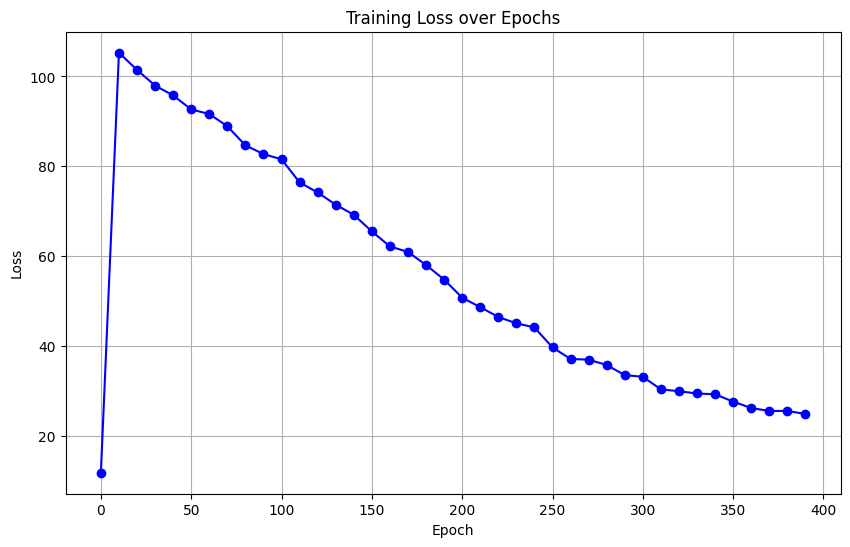

In [ ]:
import matplotlib.pyplot as plt

epochs = [
    0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
    160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290,
    300, 310, 320, 330, 340, 350, 360, 370, 380, 390
]
losses = [
    11.7118999005761, 105.27776907754014, 101.45478522218764, 97.96161541804031,
    95.7652038520173, 92.64628775657911, 91.62508884524868, 88.90302349776903,
    84.6358380591555, 82.70271758512536, 81.53195204613439, 76.3927595877758,
    74.14106083381193, 71.42537906522921, 69.16221529991162, 65.47076485656726,
    62.1360088881047, 60.89056803673884, 57.985315461344726, 54.73302427918679,
    50.69724302080431, 48.59712202517403, 46.407517315681616, 44.99496047659704,
    44.07751854383969, 39.62402399040002, 37.051896732489695, 36.89249631060375,
    35.71413582353853, 33.45783720578038, 33.08240255239798, 30.282505852694158,
    29.86848702972202, 29.363934024146147, 29.187604612583527, 27.543819716789585,
    26.130621485815936, 25.465440133120865, 25.48384229660587, 24.789676978944044
]

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
import torch
drive.mount('/content/drive')
torch.save(unet.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/Action_Learning/models/unet_model.pth")

Mounted at /content/drive


In [ ]:
from transformers import PreTrainedModel, PretrainedConfig
from google.colab import userdata
token = userdata.get('Admin')

class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.unet = unet.to('cpu')


Model(PretrainedConfig()).push_to_hub(
    repo_id='callmeeric5/stable_diffusion.unet',
    use_auth_token=token)

pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/callmeeric5/stable_diffusion.unet/commit/124e1ce6b8b9a734ad43f5617ac0274c419dfcd1', commit_message='Upload model', commit_description='', oid='124e1ce6b8b9a734ad43f5617ac0274c419dfcd1', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# push to hub clip
class CLIPEncoderModel(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.encoder = encoder.to('cpu')



CLIPEncoderModel(PretrainedConfig()).push_to_hub(
    repo_id='callmeeric5/stable_diffusion.clip',
    use_auth_token=token)

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/callmeeric5/stable_diffusion.clip/commit/b168358bfb57d40e64d55cce175e39f1e82a876f', commit_message='Upload model', commit_description='', oid='b168358bfb57d40e64d55cce175e39f1e82a876f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# push to hub vae
class VAEModel(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.vae = vae.to('cpu')

    def encode(self, x):
        return self.vae.encoder(x)

    def decode(self, z):
        return self.vae.decoder(z)

VAEModel(PretrainedConfig()).push_to_hub(
    repo_id='callmeeric5/stable_diffusion.vae',
    use_auth_token=token)

pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/callmeeric5/stable_diffusion.vae/commit/96cf5ae9abb68d7ac5230fecaa1aa3705c00af26', commit_message='Upload model', commit_description='', oid='96cf5ae9abb68d7ac5230fecaa1aa3705c00af26', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
encoder.eval()
vae.eval()
unet.eval()

@torch.no_grad()
def generate(text):
    #text encoder
    #[1, 77]
    pos = tokenizer(text,
                    padding='max_length',
                    max_length=77,
                    truncation=True,
                    return_tensors='pt').input_ids.to(device)
    neg = tokenizer('',
                    padding='max_length',
                    max_length=77,
                    truncation=True,
                    return_tensors='pt').input_ids.to(device)

    #[1, 77, 768]
    pos = encoder(pos)
    neg = encoder(neg)

    #[1+1, 77, 768] -> [2, 77, 768]
    out_encoder = torch.cat((neg, pos), dim=0)

    #vae的压缩图,从随机噪声开始
    out_vae = torch.randn(1, 4, 64, 64, device=device)

    #50 time steps
    scheduler.set_timesteps(50, device=device)
    for time in scheduler.timesteps:

        #add noise
        #[1+1, 4, 64, 64] -> [2, 4, 64, 64]
        noise = torch.cat((out_vae, out_vae), dim=0)
        noise = scheduler.scale_model_input(noise, time)

        #compute noise
        #[2, 4, 64, 64],[2, 77, 768],scala -> [2, 4, 64, 64]
        pred_noise = unet(out_vae=noise, out_encoder=out_encoder, time=time)

        #demish noise
        #[2, 4, 64, 64] -> [1, 4, 64, 64]
        pred_noise = pred_noise[0] + 7.5 * (pred_noise[1] - pred_noise[0])

        #add noise
        #[1, 4, 64, 64]
        out_vae = scheduler.step(pred_noise, time, out_vae).prev_sample

    #noise to image
    out_vae = 1 / 0.18215 * out_vae
    #[1, 4, 64, 64] -> [1, 3, 512, 512]
    image = vae.decoder(out_vae)

    #image data
    image = image.cpu()
    image = (image + 1) / 2
    image = image.clamp(0, 1)
    image = image.permute(0, 2, 3, 1)
    return image.numpy()[0]


generate('a drawing of a star with a jewel in the center').shape

(512, 512, 3)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

def inference():
    texts = [
        'a drawing of a star with a jewel in the center',
        'a drawing of a woman in a red cape',
        'a drawing of a dragon sitting on its hind legs',
        'a drawing of a blue sea turtle holding a rock',
        'a blue and white bird with its wings spread',
        'a blue and white stuffed animal sitting on top of a white surface',
    ]

    images = [generate(i) for i in texts]

    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()


config.json:   0%|          | 0.00/105 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

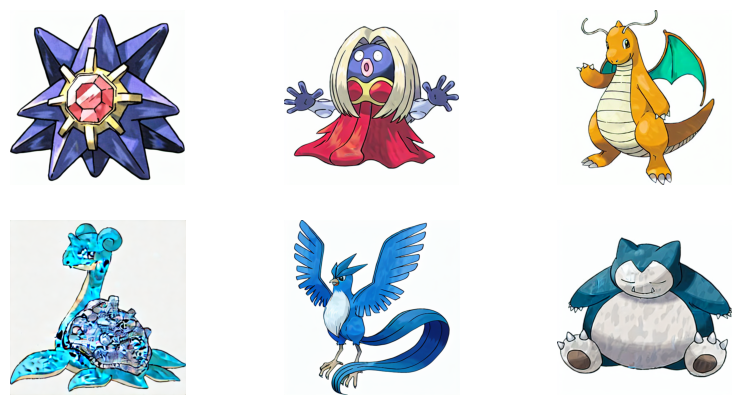

In [ ]:
#Load model from hugging_face
from transformers import PreTrainedModel, PretrainedConfig
class Model(PreTrainedModel):
    config_class = PretrainedConfig
    def __init__(self, config):
        super().__init__(config)
        self.unet = unet.to('cpu')

unet = Model.from_pretrained("callmeeric5/stable_diffusion.unet").unet
unet.eval().to(device)

inference()

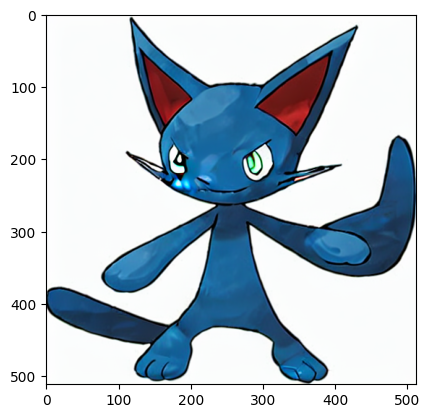

In [ ]:
text = 'a cat with a blue hat and it has a long red tail'
unet.eval().to(device)
image = generate(text)
plt.imshow(image)

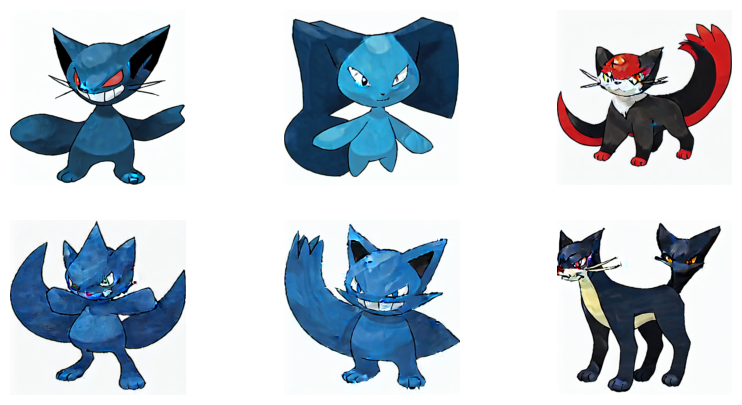

In [ ]:
def inference():
    texts = [
        'a cat with a blue hat and it has a long red tail',
        'a cat with a blue hat',
        'a cat has a long red tail',
        'a cat with a blue hat holdng a bamboo and it has a long red tail',
        'a cat with a blue hat holdng a bamboo',
        'a cat',
    ]

    images = [generate(i) for i in texts]

    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()

unet.eval().to(device)

inference()

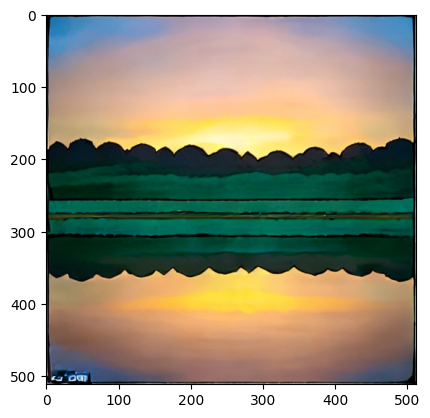

In [ ]:
text = 'The shimmering lake reflected the golden hues of the setting sun, casting a tranquil spell over the serene landscape'
unet.eval().to(device)
image = generate(text)
plt.imshow(image)

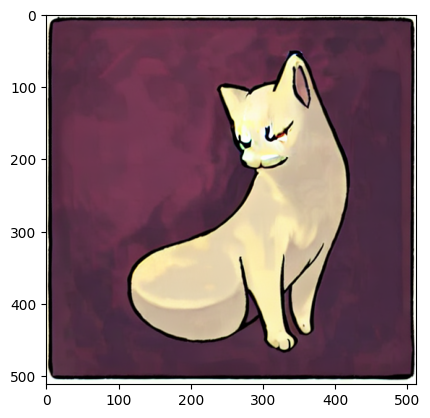

In [ ]:
text = 'The cat lounged lazily on the sunlit windowsill.'
unet.eval().to(device)
image = generate(text)
plt.imshow(image)